<a href="https://colab.research.google.com/github/Samir-atra/BDSD_Minor_Project/blob/main/MediaPipe_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download and install packages
!python -m pip install mediapipe
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
!wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

# Imports
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import csv
import pandas as pd
import tensorflow as tf
# import albumentations as A
import math

In [2]:
# MediaPipe visualizations


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()


In [3]:
# download and upload images
# download
# img = cv2.imread("images.jpg")
# cv2_imshow(img)

#upload
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

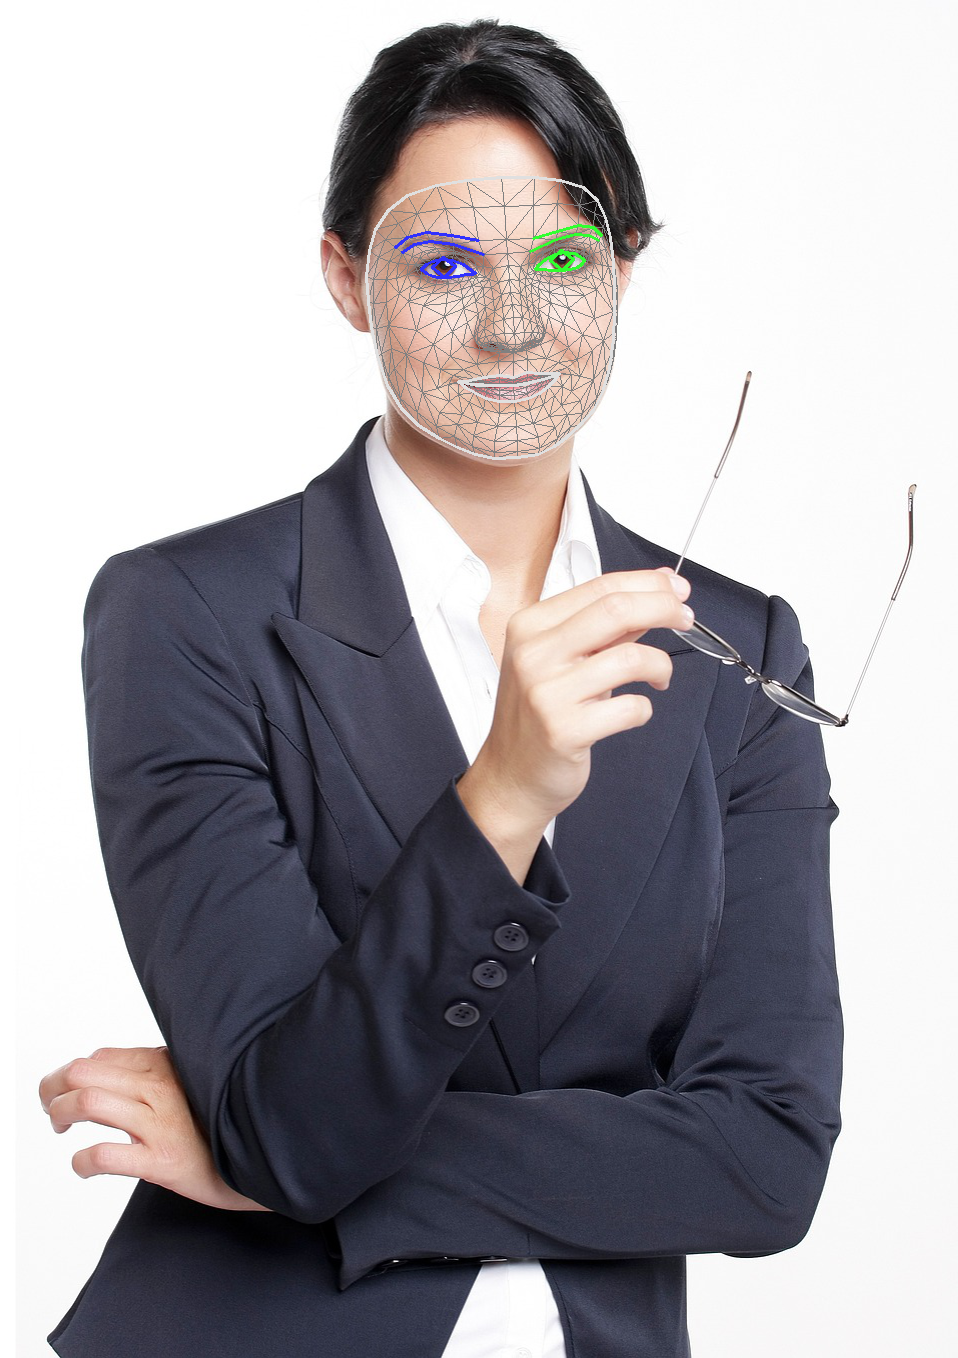

In [4]:
#inferencing and visualizing

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
# print(detection_result.facial_transformation_matrixes)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

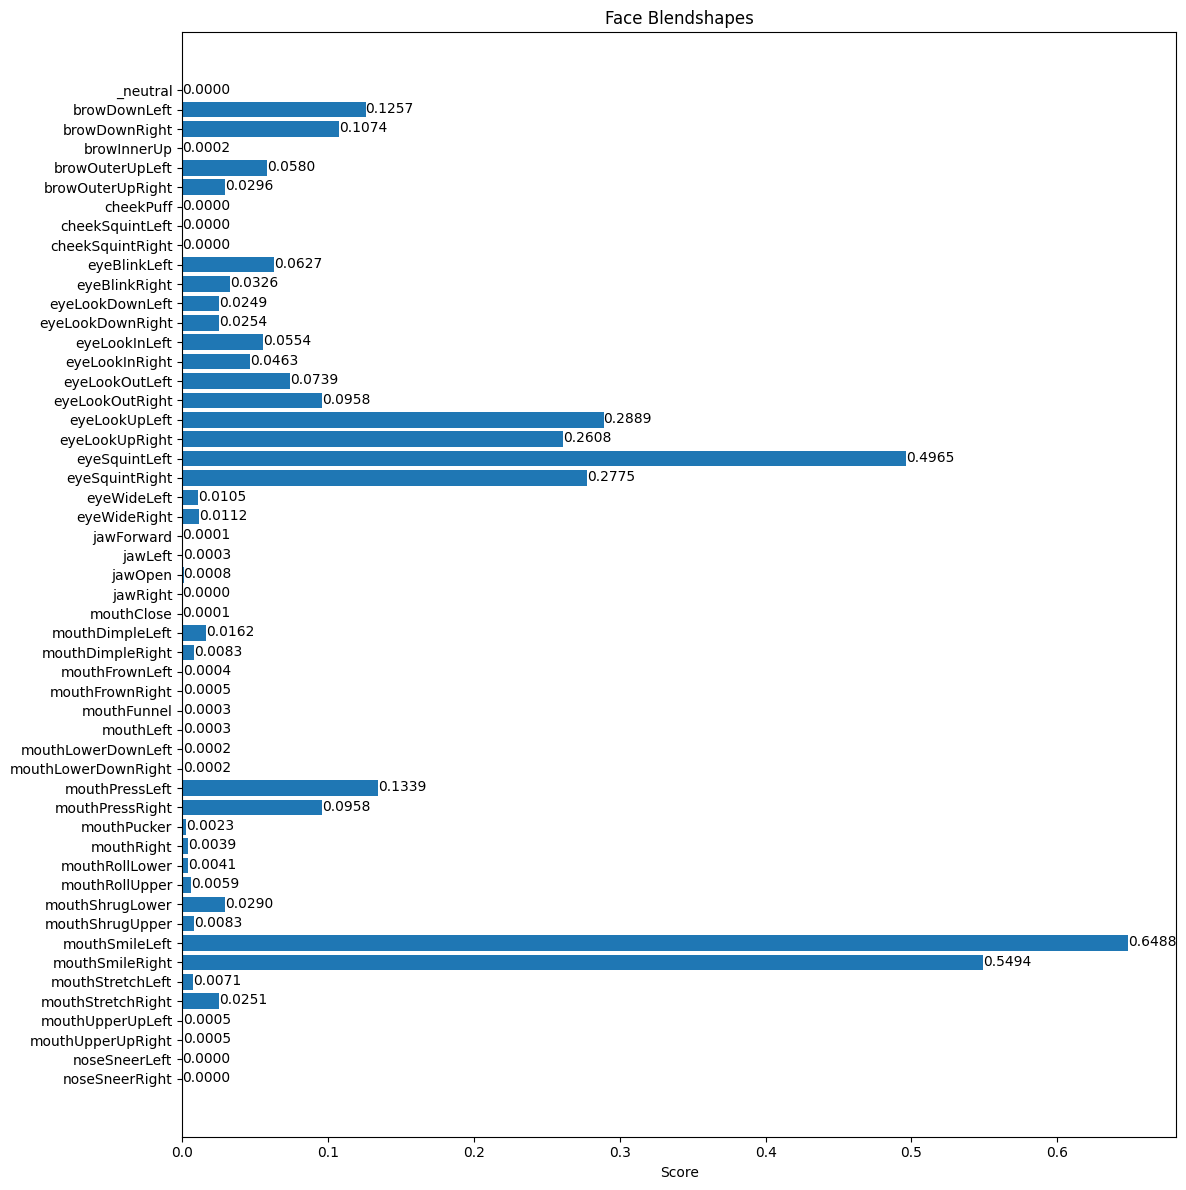

[Category(index=0, score=2.72534475698194e-06, display_name='', category_name='_neutral'), Category(index=1, score=0.1256559193134308, display_name='', category_name='browDownLeft'), Category(index=2, score=0.10741737484931946, display_name='', category_name='browDownRight'), Category(index=3, score=0.0001509089197497815, display_name='', category_name='browInnerUp'), Category(index=4, score=0.05803173407912254, display_name='', category_name='browOuterUpLeft'), Category(index=5, score=0.029591243714094162, display_name='', category_name='browOuterUpRight'), Category(index=6, score=3.763052154681645e-05, display_name='', category_name='cheekPuff'), Category(index=7, score=2.0550255896978342e-07, display_name='', category_name='cheekSquintLeft'), Category(index=8, score=2.673677101938665e-07, display_name='', category_name='cheekSquintRight'), Category(index=9, score=0.06272834539413452, display_name='', category_name='eyeBlinkLeft'), Category(index=10, score=0.03263695165514946, displa

In [5]:
# plot bar graphs

plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
print(detection_result.face_blendshapes[0])

In [30]:
# Processing, cleaning and visualizing the dataset

Training_set = []
validation_set = []
test_set = []
categories_count = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}
skipped = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}

with open("training_set_hs.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  for lines in csvFile:
      Training_set.append(lines)
  # # iterate over the training dataset
  # for i in range(len(Training_set)):
  #   # print(categories_count[Training_set[i][0]])
  #   categories_count[Training_set[i][0]] = categories_count[Training_set[i][0]] + 1
  #   image = np.array(Training_set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
  #   image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  #   print(image.shape)
  #   rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
  #   detection_result = detector.detect(rgb_frame)
  #   print("emotion = ", Training_set[i][0])
  #   img = plt.imshow(image)
  #   plt.show()
  #   # Skip and delete the image if not understood by mediapipe
  #   if detection_result.face_blendshapes == []:
  #     skipped[Training_set[i][0]] = skipped[Training_set[i][0]] + 1

  #     continue

  # print("This is categories count", categories_count)
  # print("This is skipped", skipped)


# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))



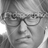

IndexError: list index out of range

In [34]:
# Augmenting images

training_images = []
training_labels = []
for i in range(math.floor(len(Training_set))):
    image = np.array(Training_set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    training_images.append(image)
    training_labels.append(int(Training_set[i][0]))


# rescaling and augmenting images models
rescaling1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
])

rescaling2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1.*255)
])

augment = tf.keras.Sequential([
  # tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0)
])

for img in training_images:
# scale down the image and augment
  image = rescaling1(training_images[0])
  aug_image = augment(image)
  # scale up the image cast to an integer and transform into a numpy array
  aug_image = rescaling2(aug_image)
  aug_image = tf.cast(aug_image, tf.uint8)
  aug_image = np.array(aug_image)
  frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=img)
  detection_result = detector.detect(frame)
  annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
  cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
  for i in detection_result.face_blendshapes[0]:
    print(i)

plt.imshow(aug_image)
plt.show()



# detect annotate and plot blendshapes for the image
# frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
# detection_result = detector.detect(frame)
# annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])


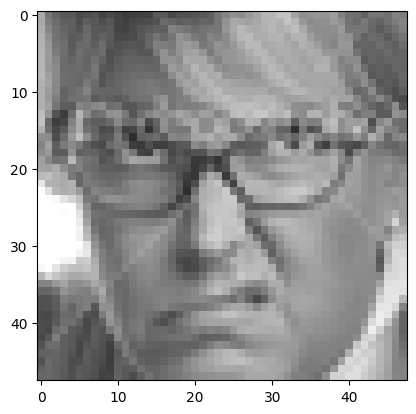

this
[]


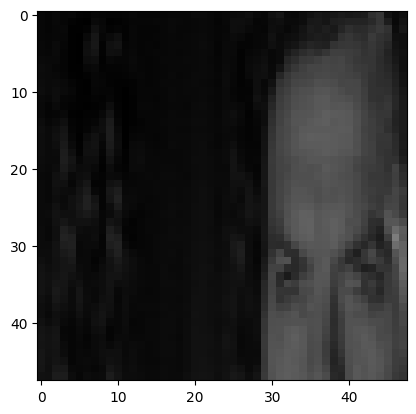

this
[]


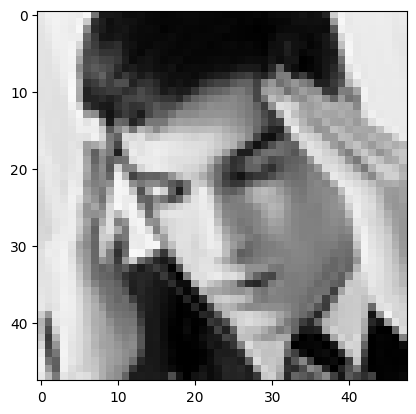

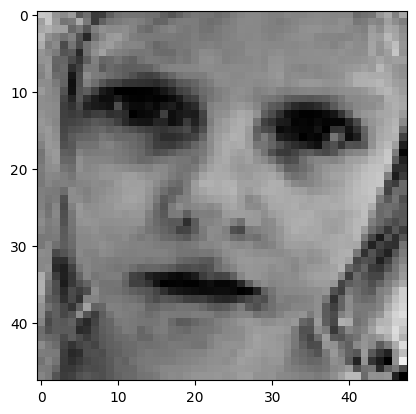

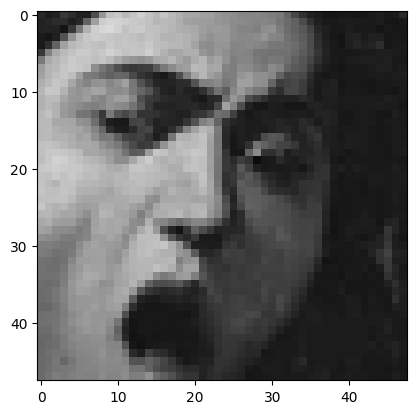

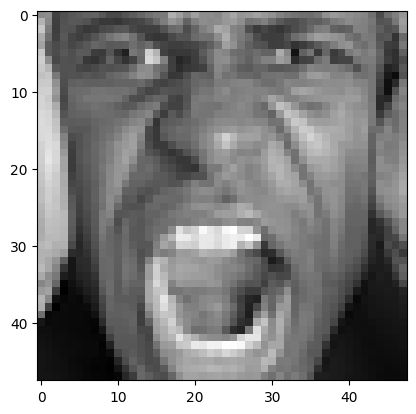

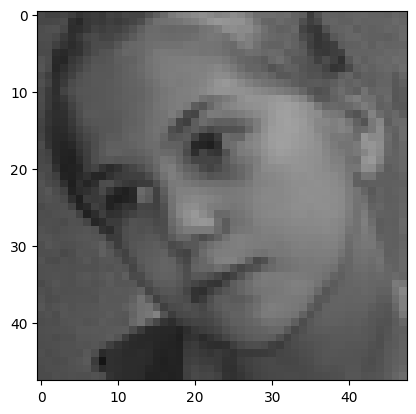

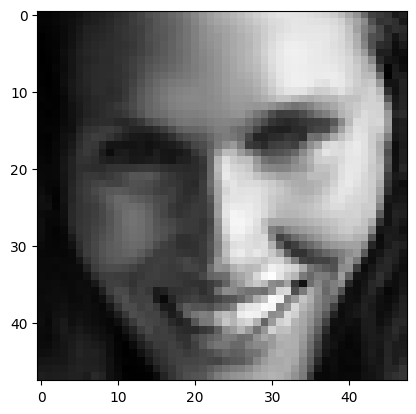

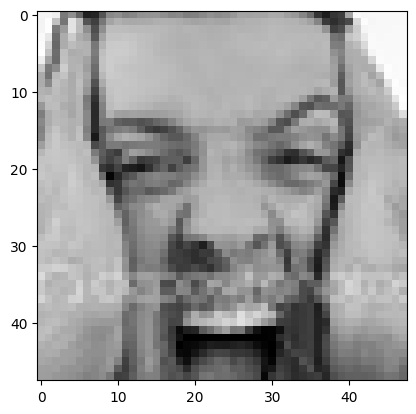

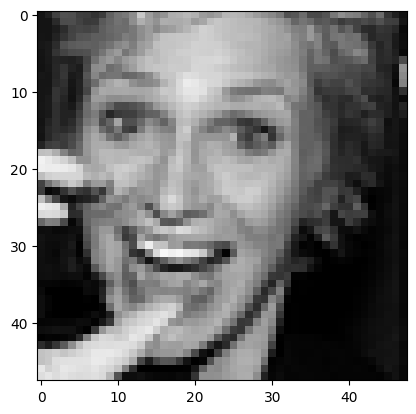

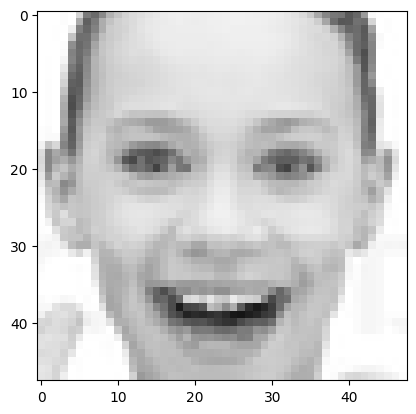

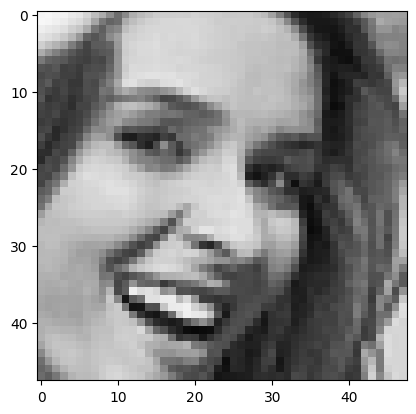

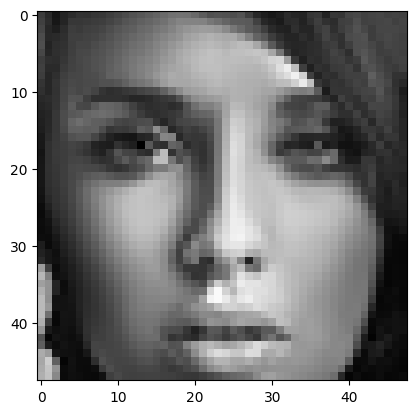

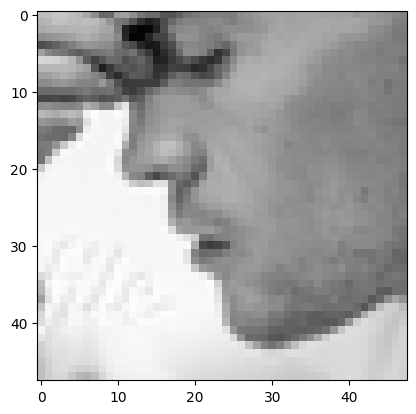

this
[]


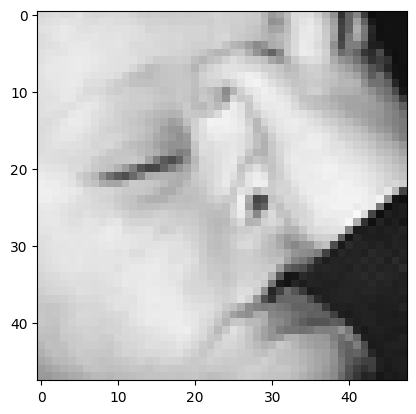

this
[]


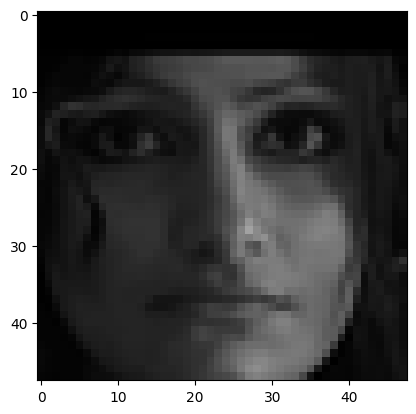

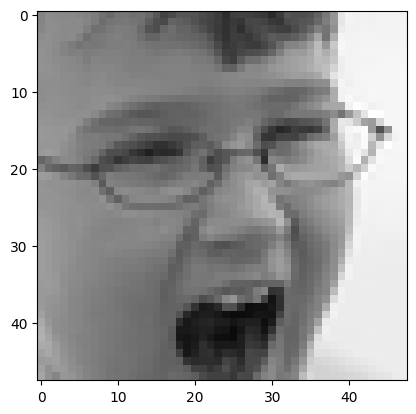

this
[]


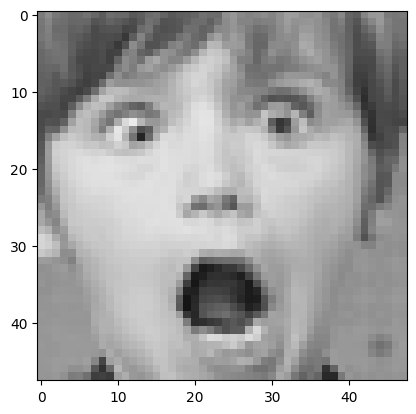

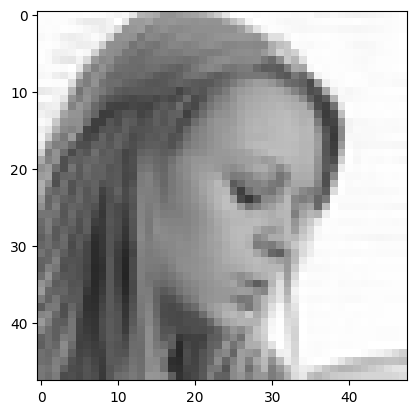

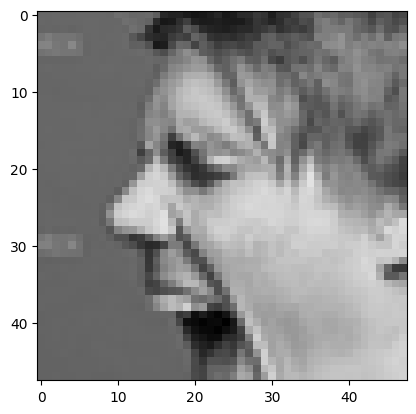

this
[]


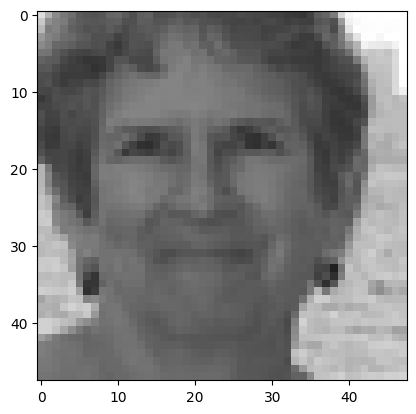

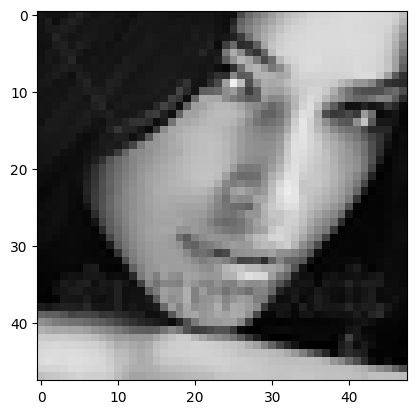

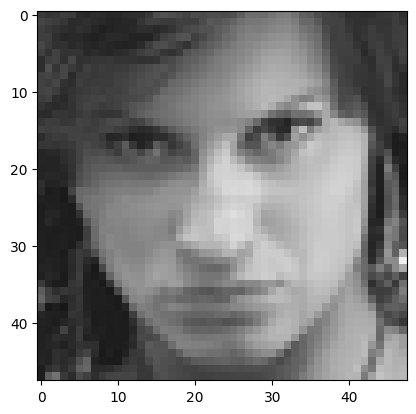

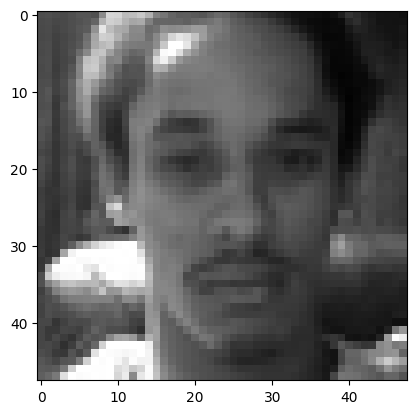

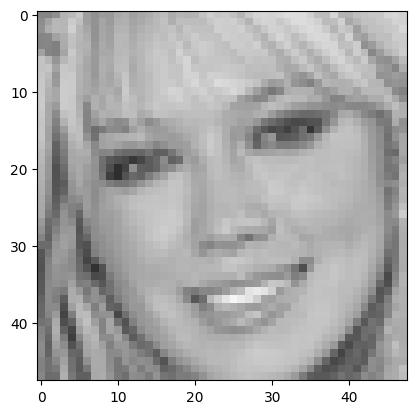

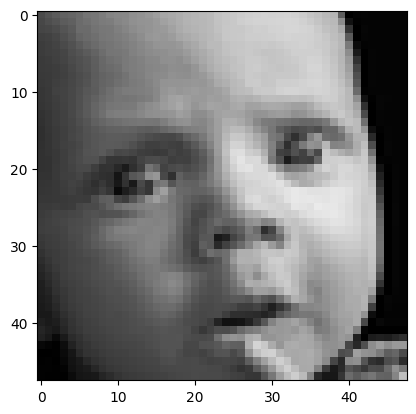

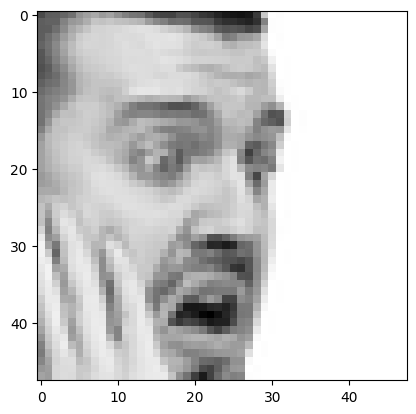

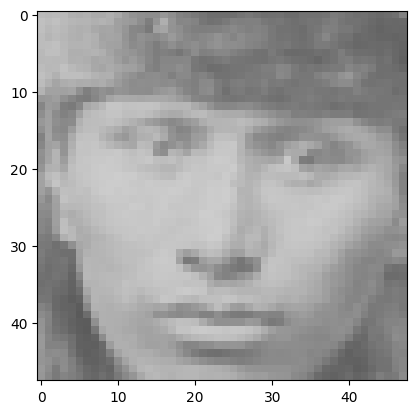

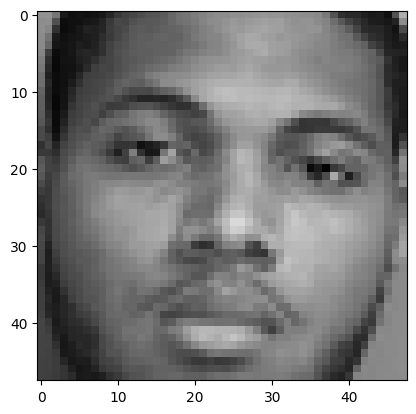

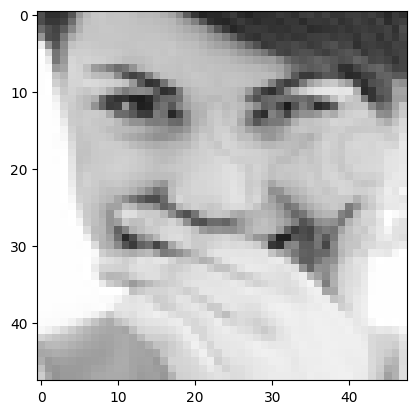

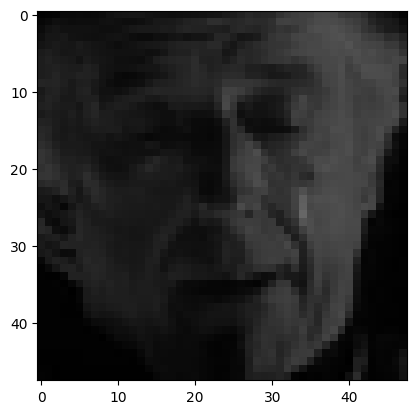

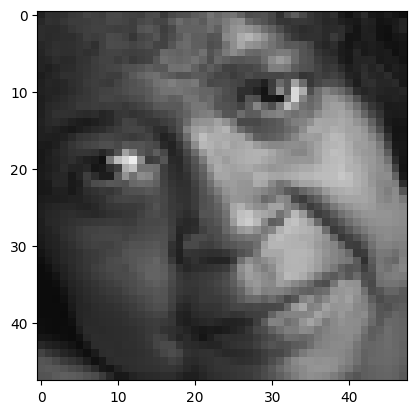

KeyboardInterrupt: 

In [38]:
# Splitting the dataset

training_set_hs = []
csv_data = "training_set_hs.csv"
with open(csv_data, mode="r") as dataset:
  for lines in Training_set:
      image = np.array(lines[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
      plt.imshow(image)
      plt.show()
      frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
      detection_result = detector.detect(frame)
      if detection_result.face_blendshapes == []:
        print("this")
        print(detection_result.face_blendshapes)
        continue
      else:
        training_set_hs.append(lines)
  # for lines in csvFile:
  #   if lines[2] == "PrivateTest":
  #     test_set.append(lines)


# csvfile = "test_set_hs.csv"
# fields = ["emotion", "pixels", "Usage"]
# with open(csvfile, mode="a") as first:
#   csvwriter = csv.writer(first)
#   csvwriter.writerow(fields)
#   csvwriter.writerows(test_set_hs)
# print(len(test_set_hs))
# csvfile2 = "validation_set.csv"
# fields = ["emotion", "pixels", "Usage"]
# with open(csvfile2, mode="a") as second:
#   csvwriter = csv.writer(second)
#   csvwriter.writerow(fields)
#   csvwriter.writerows(validation_set)

# csvfile3 = "test_set.csv"
# fields = ["emotion", "pixels", "Usage"]
# with open(csvfile3, mode="a") as third:
#   csvwriter = csv.writer(third)
#   csvwriter.writerow(fields)
#   csvwriter.writerows(test_set)

In [ ]:
# classification

if detection_result.face_blendshapes[0][44].score > 0.5 and detection_result.face_blendshapes[0][45].score > 0.5 :
  print("Happy")
elif detection_result.face_blendshapes[0][42].score > 0.5:
  print("Sad")
